In [1]:
import jax
import jax.numpy as jnp
import optax
import pandas as pd

from model import u,m,policy,F,T

import nndp

Solves a cake eating problem by choosing how much cake to consume. $c_t$ is the share of cake consumed at time $t$.

$$V(s_0)=\sum_{t=0}^T u(c_ts_t)$$

$$s_{t+1}=(1-c_t)s_t$$

In [10]:

key = jax.random.PRNGKey(1)
key, subkey = jax.random.split(key)


params, nn = nndp.initialize_deep_nn(subkey,
                                n_states = 2,
                                n_actions = 1,
                                nodes_per_layer=100,
                                hidden_layers=4,
                                hidden_activation=jax.nn.tanh,
                                output_activation=[jax.nn.sigmoid])

key, subkey = jax.random.split(key)

params, train_result = nndp.core.train(key = subkey,
               params = params,
               nn = nn,
               policy = policy,
               u = u,
               m = m,
               F = F,
               T = T,
               N_simul = 1,
               batch_size = 250,
               epochs = 200,
               optimizer = optax.adam(1e-3)
               )

Objective value on training iteration 199 out of 200: -16.273653030395508

In [11]:
data = pd.DataFrame({'t':range(0,T+1), 's':0, 'policy':0}).astype(float)

data.loc[0,'s'] = 1
for t in range(T+1):
  s = jnp.array(data.loc[t,['t','s']].to_numpy().astype('float32')).reshape(-1,2)
  data.loc[t,'policy'] = policy(s,params, nn)[0][0]
  s_next = m(1,s,policy(s,params,nn)).squeeze()
  if t<T:
    data.loc[t+1,['t','s']] = s_next
data

,t,s,policy
0,0.0,1.000000,0.165114
1,1.0,0.834886,0.194695
2,2.0,0.672338,0.248999
3,3.0,0.504926,0.331254
4,4.0,0.337668,0.482803
5,5.0,0.174641,0.991964


<Axes: title={'center': 'Convergence of Objective Function'}, xlabel='Epoch', ylabel='Objective Function'>

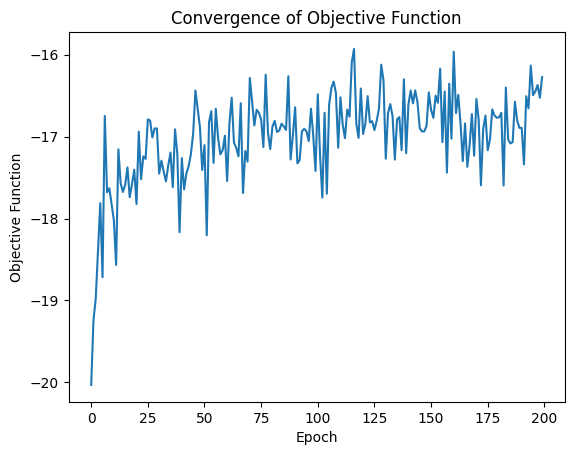

In [13]:
train_result.plot_convergence()